%run feature_engineering.ipynb

In [510]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import copy


import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.metrics import mean_squared_error


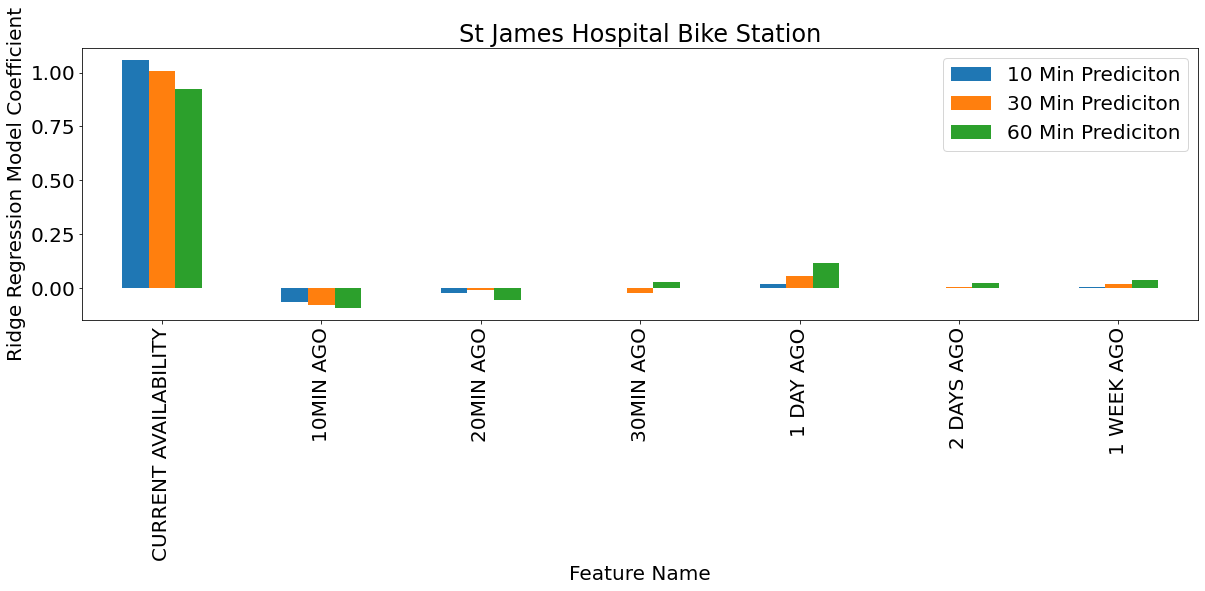

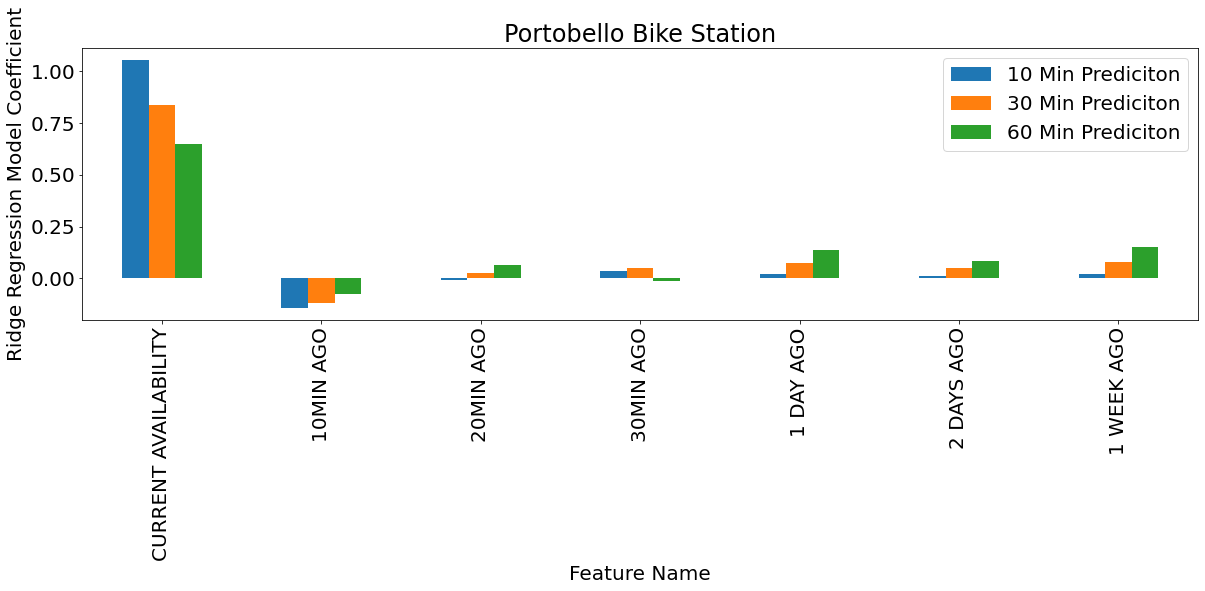

In [511]:
%run feature_engineering.ipynb

Lets save our variables from the previous notebook

In [512]:

df_hospital_map = df_hospital_map
df_portobello_map = df_portobello_map

X_hospital_map = X_hospital
y_hospital_map = y_hospital

X_portobello_map = X_portobello
y_portobello_map = y_portobello


In [513]:
def test_and_train_model(model,df :pd.DataFrame, X, y, title:str):
    cv = TimeSeriesSplit(n_splits=5)
    mse_scores=[]
    split_count=0
    X = X.to_numpy()
    y = y.to_numpy()
    for train, test in cv.split(X):
        model.fit(X[train], y[train])
        ypred = model.predict(X[test])
        mse_scores.append(mean_squared_error(y[test], ypred))
        split_count=split_count+1
        if split_count == 5:
            plt.rc('font',size=30)
            plt.figure(figsize=(30,20))
            plt.scatter(df.iloc[test].index,y[test],label="actual",marker='o')
            plt.scatter(df.iloc[test].index,ypred,label="predicted")
            plt.xlim(df.iloc[test].index[0],df.iloc[test].index[-1])
            plt.legend()
            plt.xlabel("Time")
            plt.ylabel("Available Bikes")
            

    print("MSE: "+str(np.mean(mse_scores)))
    plt.title(title+" MSE: "+str(np.mean(mse_scores)))

In [514]:
def test_and_train_model(model_name:str,model, X, y):
    
    kf = KFold(n_splits=5)
    mse_scores=[]
    
    X = X.to_numpy()
    y = y.to_numpy()
    
    for train,test in kf.split(X):
        model.fit(X[train], y[train])
        ypred = model.predict(X[test])
        mse_scores.append(mean_squared_error(y[test], ypred))
    

    return np.mean(mse_scores), np.std(mse_scores)
    

In [515]:
df_hospital_map["60MIN"]

,BIKE STANDS,AVAILABLE BIKES,CURRENT AVAILABILITY,10MIN AGO,20MIN AGO,30MIN AGO,1 DAY AGO,2 DAYS AGO,1 WEEK AGO
TIME,,,,,,,,,
2020-02-18 01:30:02,40,0.825,0.825,0.825,0.825,0.825,0.375,0.475,0.25
2020-02-18 01:35:02,40,0.825,0.825,0.825,0.825,0.825,0.375,0.475,0.25
2020-02-18 01:40:02,40,0.825,0.825,0.825,0.825,0.825,0.375,0.475,0.25
2020-02-18 01:45:02,40,0.825,0.825,0.825,0.825,0.825,0.375,0.475,0.25
2020-02-18 01:50:02,40,0.825,0.825,0.825,0.825,0.825,0.375,0.475,0.25
...,...,...,...,...,...,...,...,...,...
2020-03-12 23:35:02,40,0.550,0.575,0.550,0.550,0.575,0.225,0.500,0.70
2020-03-12 23:40:02,40,0.550,0.575,0.575,0.550,0.575,0.225,0.500,0.70
2020-03-12 23:45:02,40,0.550,0.575,0.575,0.550,0.550,0.250,0.500,0.70


In [516]:
def cross_evaluate_models(model_name:str,hyper_param_range, X_map,y_map):
    

    cross_evaluation_map = {
        "C":[],
        "MEAN":[],
        "STD ERROR":[]
    }
    model_scores={
        "10MIN": copy.deepcopy(cross_evaluation_map),
        "30MIN":copy.deepcopy(cross_evaluation_map),
        "60MIN":copy.deepcopy(cross_evaluation_map)
    }
    
    
    model = DummyRegressor()

    for hyper_param in hyper_param_range:

        if model_name == "ridge":
            model = Ridge(alpha=1/(2*hyper_param))
        if model_name == "kNN":
            model = KNeighborsRegressor(n_neighbors=hyper_param)

        for key in model_scores:
            
            scores = test_and_train_model(key,model, X_map[key], y_map[key])
            
            model_scores[key]["C"].append(hyper_param)
            model_scores[key]["MEAN"].append(scores[0])
            model_scores[key]["STD ERROR"].append(scores[1])


    return model_scores

In [517]:
def plot_cross_eval(model_scores,title,hyper_param_name):
    plt.figure(figsize=(30,10))
    plt.errorbar(model_scores["10MIN"]["C"],model_scores["10MIN"]["MEAN"],yerr=model_scores["10MIN"]["STD ERROR"], label = "10 min prediction")
    plt.errorbar(model_scores["30MIN"]["C"],model_scores["30MIN"]["MEAN"],yerr=model_scores["30MIN"]["STD ERROR"], label = "30 min prediction")
    plt.errorbar(model_scores["60MIN"]["C"],model_scores["60MIN"]["MEAN"],yerr=model_scores["60MIN"]["STD ERROR"], label = "60 min prediction")
    plt.legend()
    plt.xlabel(hyper_param_name)
    plt.ylabel("MSE")
    plt.title(title)

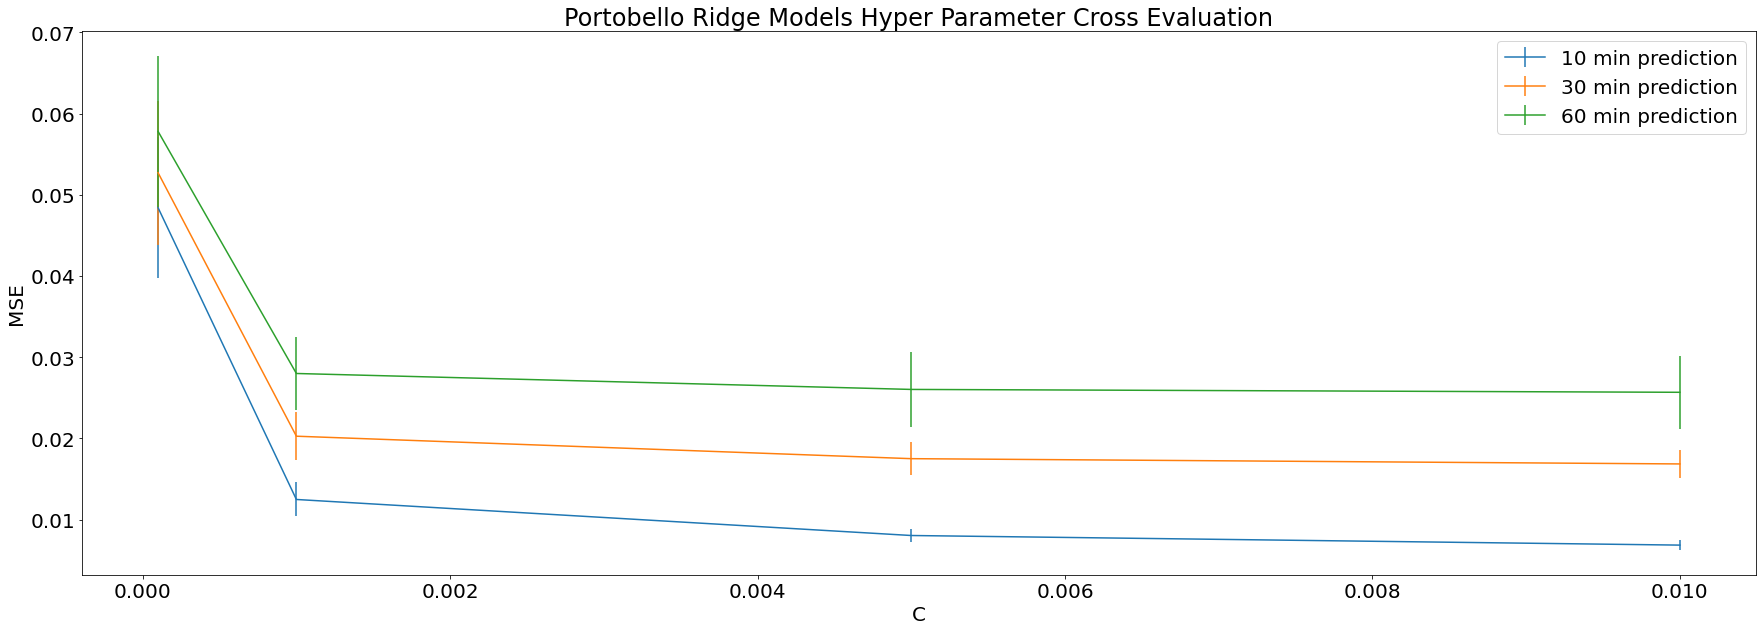

In [518]:
portobello_model_scores = cross_evaluate_models("ridge", [0.0001,0.001,0.005,0.01],X_portobello_map, y_portobello_map)

plot_cross_eval(portobello_model_scores,"Portobello Ridge Models Hyper Parameter Cross Evaluation","C")

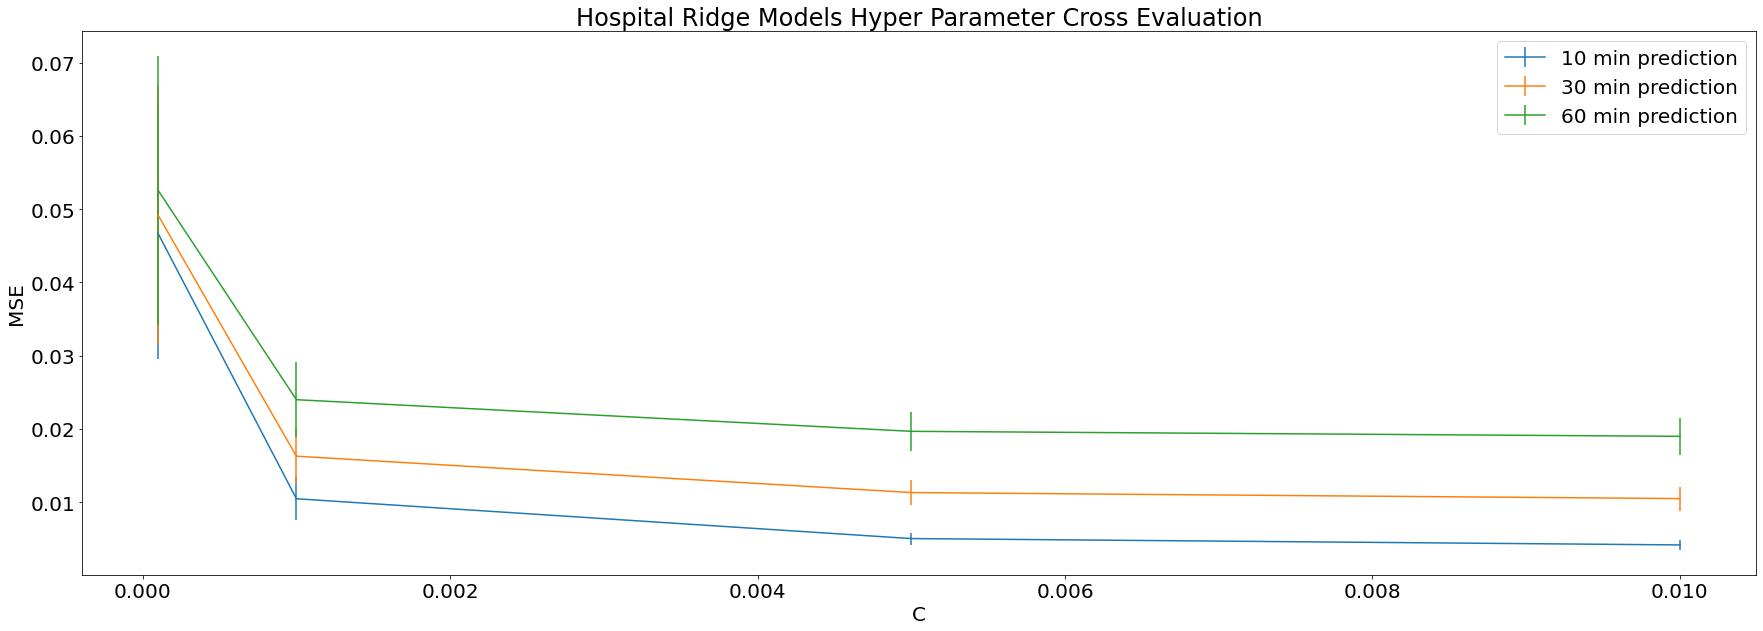

In [519]:
hospital_model_scores = cross_evaluate_models("ridge", [0.0001,0.001,0.005,0.01],X_hospital_map, y_hospital_map)

plot_cross_eval(hospital_model_scores,"Hospital Ridge Models Hyper Parameter Cross Evaluation","C")

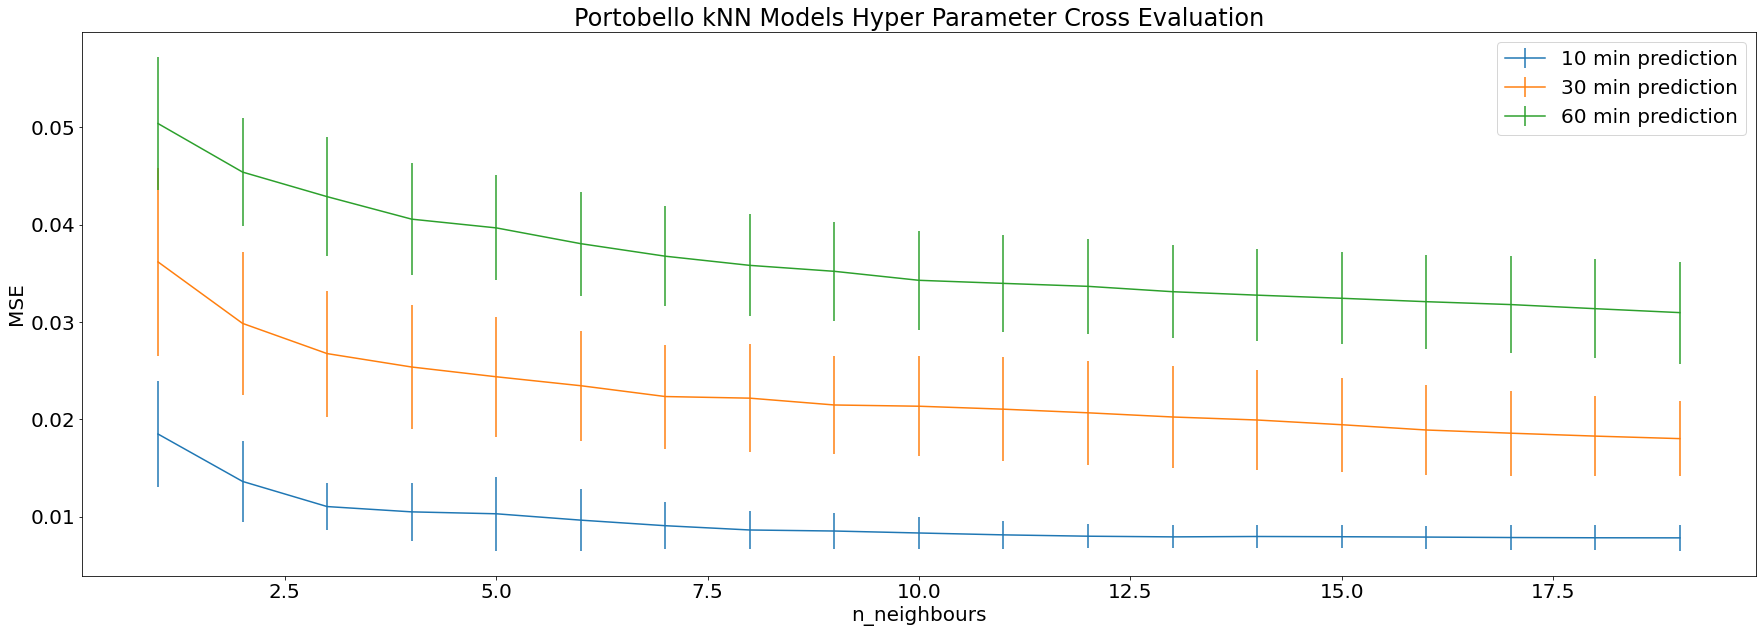

In [520]:
portobello_model_scores = cross_evaluate_models("kNN", range(1,20),X_hospital_map, y_hospital_map)

plot_cross_eval(portobello_model_scores,"Portobello kNN Models Hyper Parameter Cross Evaluation","n_neighbours")

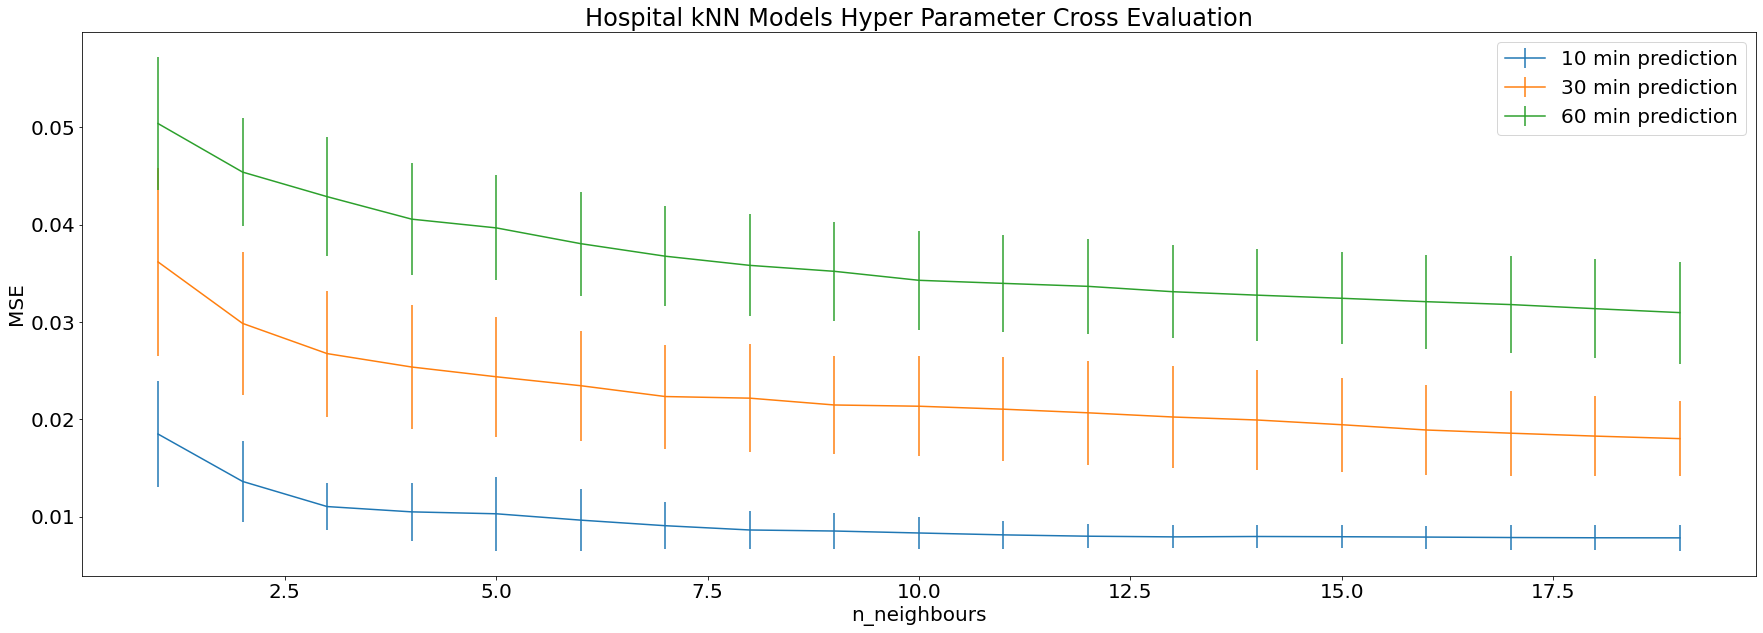

In [521]:
hospital_model_scores = cross_evaluate_models("kNN", range(1,20),X_hospital_map, y_hospital_map)

plot_cross_eval(portobello_model_scores,"Hospital kNN Models Hyper Parameter Cross Evaluation","n_neighbours")

In [532]:
def visualise_models(model, df :pd.DataFrame, X_map, y_map, title:str):
    test=-2000
    train = np.size(X_map["10MIN"])+test
    
    ypreds={}
    for key in X_map:
        model.fit(X_map[key][:train],y_map[key][:train])
        ypreds[key] = model.predict(X_map[key][test:])


    plt.rc('font',size=30)
    plt.figure(figsize=(20,15))
    plt.plot(df.iloc[test:].index,y_map["10MIN"][test:],label="actual",marker='o')
    plt.plot(df.iloc[test:].index,ypreds["10MIN"],label="10 min prediction")
    plt.plot(df.iloc[test:].index,ypreds["30MIN"],label="30 min prediction")
    plt.plot(df.iloc[test:].index,ypreds["60MIN"],label="60 min prediction")
    plt.xlim(df.iloc[test:].index[0],df.iloc[test::].index[-1])
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Available Bikes")
    plt.title(title)

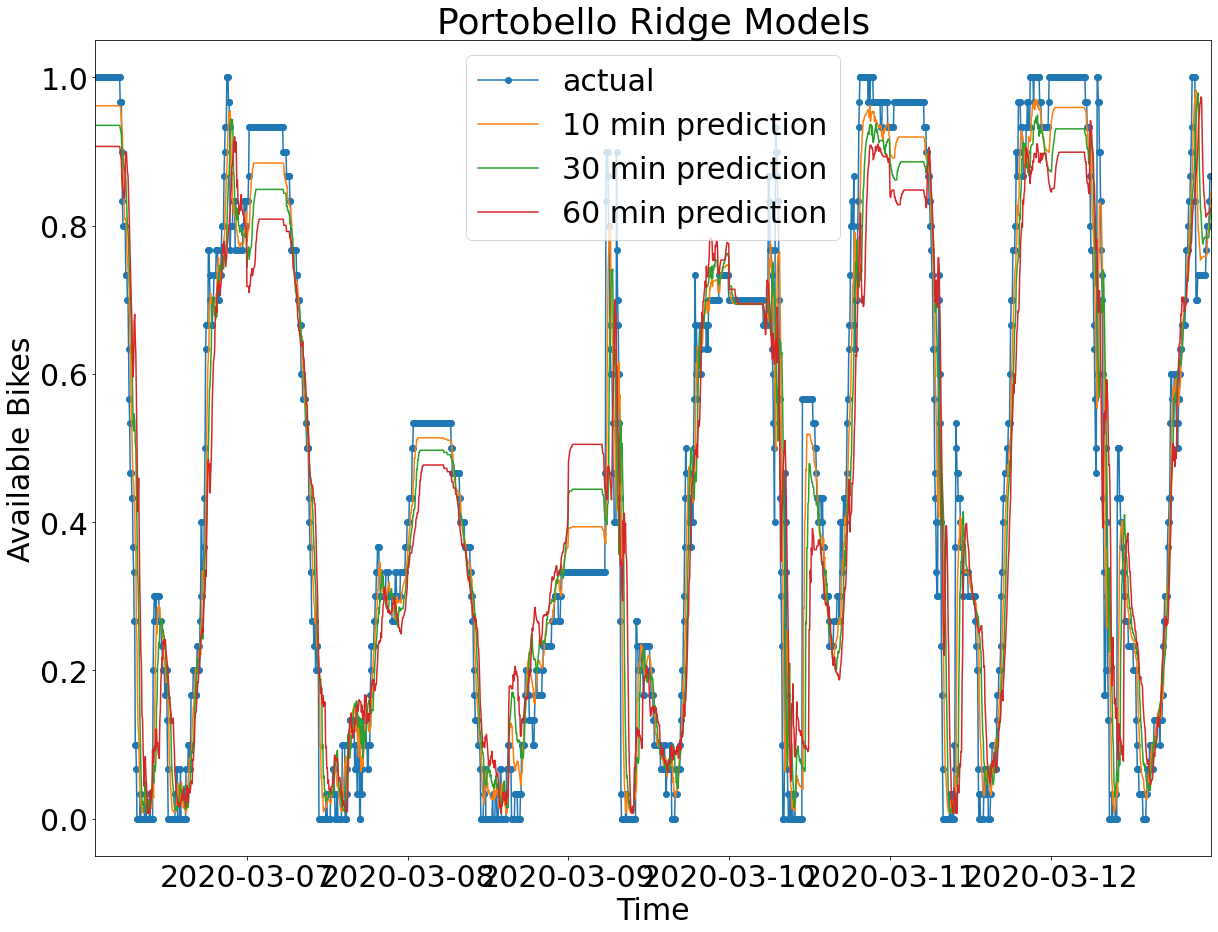

In [533]:
visualise_models(Ridge(alpha = 1/(2*0.005)),df_portobello_map["10MIN"],X_portobello_map,y_portobello_map,"Portobello Ridge Models")

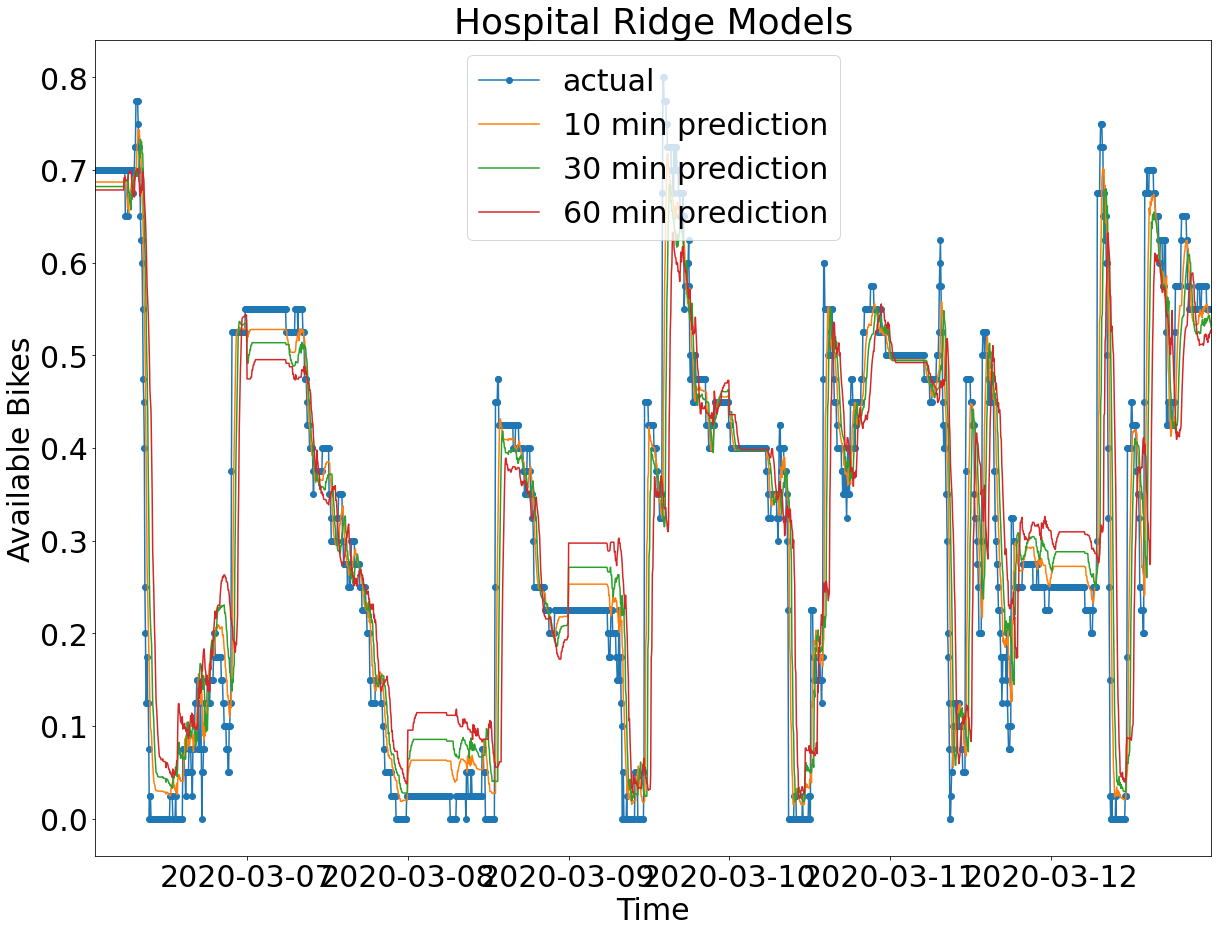

In [534]:
visualise_models(Ridge(alpha = 1/(2*0.005)),df_hospital_map["10MIN"],X_hospital_map,y_hospital_map,"Hospital Ridge Models")

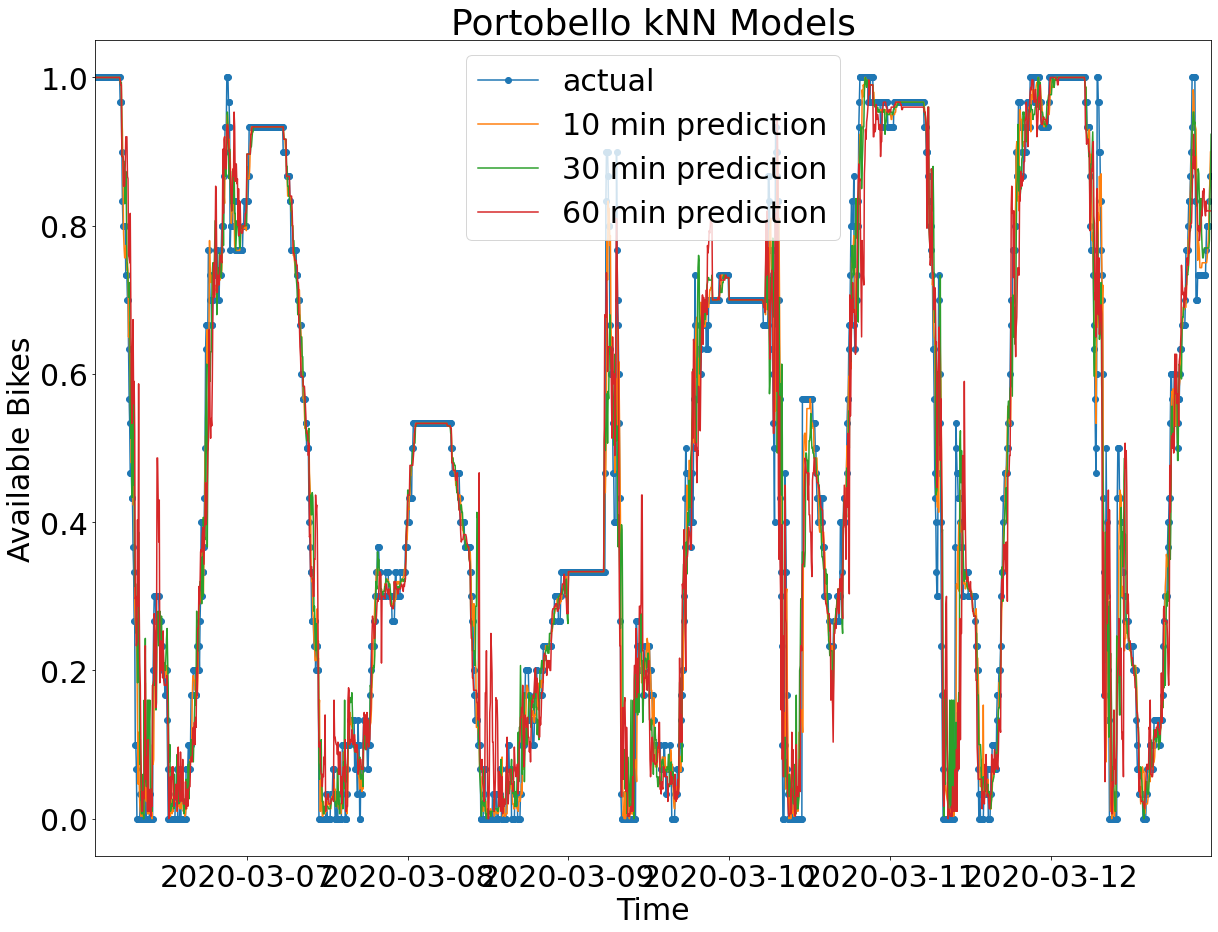

In [535]:
visualise_models(KNeighborsRegressor(n_neighbors=10),df_portobello_map["10MIN"],X_portobello_map,y_portobello_map,"Portobello kNN Models")


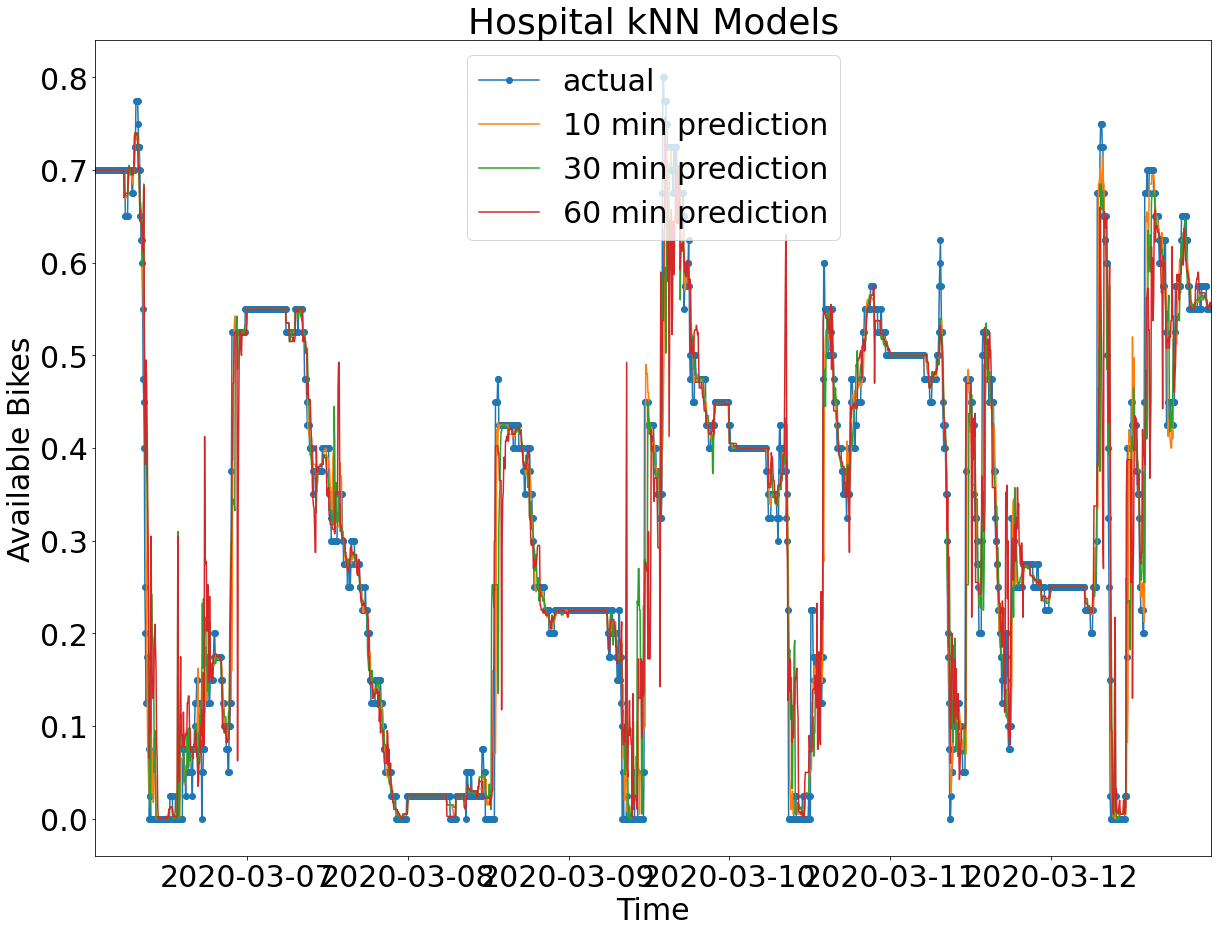

In [536]:
visualise_models(KNeighborsRegressor(n_neighbors=10),df_portobello_map["10MIN"],X_hospital_map,y_hospital_map,"Hospital kNN Models")